In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
%matplotlib inline
np.set_printoptions(precision=3)

In [2]:
from hurst import compute_Hc, random_walk

In [3]:
import dx

In [4]:
with open("config/keys.json", "r") as read_file:
    config = json.load(read_file)

In [5]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=config["alphavantage"], output_format="pandas")

In [6]:
data, meta_data = ts.get_daily_adjusted("TLT", outputsize="full")
data.columns = ["open", "high", "low", "close", "price", "volume", "div", "coef"]

In [7]:
data.head()

,open,high,low,close,price,volume,div,coef
date,,,,,,,,
2019-12-24,135.92,137.0600,135.8900,136.84,136.8400,4667060.0,0.0000,1.0
2019-12-23,136.81,136.9687,136.0000,136.45,136.4500,5179291.0,0.0000,1.0
2019-12-20,136.13,136.6900,135.9300,136.65,136.6500,5455919.0,0.0000,1.0
2019-12-19,136.00,136.8600,135.7601,136.47,136.4700,6591083.0,0.2176,1.0
2019-12-18,137.30,137.4500,136.2800,136.47,136.2527,6244828.0,0.0000,1.0


In [8]:
H, c, hc_data = compute_Hc(data["price"], kind="price", simplified=True)

In [9]:
H

0.6650126157377606

In [10]:
c

0.7494500445905503

In [11]:
r = dx.constant_short_rate('r', 0.0)

In [12]:
me = dx.market_environment(
    name='me',
    pricing_date=dt.datetime(2019, 12, 24)
)

In [13]:
me.add_constant('initial_value', 36.0)
me.add_constant('volatility', 0.3)
me.add_constant('final_date', dt.datetime(2020, 4, 17))
me.add_constant('currency', 'USD')
me.add_constant('frequency', 'D')
me.add_constant('paths', 1000)
me.add_curve('discount_curve', r)

me.add_constant('rho', -.2) # correlation between risk factor process (eg index) and variance process
me.add_constant('kappa', 0.075) # mean reversion factor
me.add_constant('theta', 0.5) # long-term variance level
me.add_constant('vol_vol', 0.1) # volatility factor for variance process

me.add_constant('lambda', 0.05) # probability for a jump p.a.
me.add_constant('mu', -0.15) # expected relative jump size
me.add_constant('delta', 0.25) # standard deviation of relative jump

In [125]:
svjd = dx.stoch_vol_jump_diffusion('svjd', me)
paths = svjd.get_instrument_values()
pdf = pd.DataFrame(paths, index=svjd.time_grid)

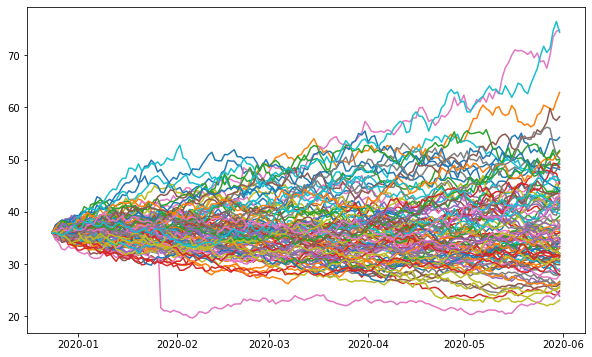

In [126]:
plt.figure(figsize=(10,6))
plt.plot(pdf[pdf.columns[:100]])
plt.show()

In [127]:
vols = svjd.get_volatility_values()
pdf_vols = pd.DataFrame(vols, index=svjd.time_grid)

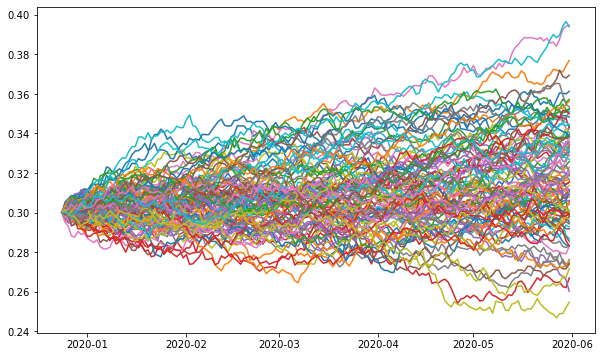

In [128]:
plt.figure(figsize=(10,6))
plt.plot(pdf_vols[pdf_vols.columns[:100]])
plt.show()

In [32]:
d["dv"] = d["close"] * d["volume"]

In [33]:
d["dv"].cumsum()

0            -29.225
1            -58.580
2            -87.715
3           -116.950
4           -146.225
            ...     
49165   -1639654.330
49166   -1639698.545
49167   -1639742.750
49168   -1639786.975
49169   -1639831.130
Name: dv, Length: 49170, dtype: float64

In [28]:
dbars = bars.dollar_bar(data_raw, m=10000)

In [30]:
dbars.tail()

,index,open,high,low,close,volume,average,barCount,dollar_vol,cum_dollar_vol
date,,,,,,,,,,
